This is my Nth attempt at getting at a neat and flexible workflow to reliably isolate FM and CF in a horseshoebat CF call. 

2020-03-03 00:20 Some rather useful ideas:

> LOW + HIGH pass filter around CF
> get the RMS profile of the CF and RMs
> choose a threshold such that the number of sampels that share both a CF and FM label is minimised. 


-- Thejasvi Beleyur 2020-03-02 on ICE 1700 to Berlin

In [1]:
import os
import sys 
sys.path.append('../measure_horseshoe_bat_calls/')
import warnings

In [2]:
import scipy.signal as signal 
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000

In [3]:
%matplotlib notebook

In [4]:

import pandas as pd
from measure_a_horseshoe_bat_call import make_one_CFcall, measure_hbc_call, make_overview_figure
from measure_a_horseshoe_bat_call import get_peak_frequency, remove_frequency, dB, moving_rms, moving_rms_edge_robust

### The logic of it all:
I want to basically get back to some old ideas and mix+match them with some new ones:

* 1) Lowpass to get the FM, Highpass to the get CF 
* 2) Compare which regions show the most drop in energy/rms
* 3) Isolate the areas with the highest difference in energy/rms across 

In [5]:
fs = 250000.0
peak_f = 100000.0
fm_durn = 0.001
cf_durn = 0.020
call_parameter = (cf_durn, fm_durn, peak_f, 50000, 0)

cf_durn, fm_durn, peak_f, fm_bw, _ = call_parameter
eg_call =  make_one_CFcall(cf_durn+fm_durn*2, fm_durn, cf_freq=peak_f, fs=fs,
                                                           call_shape='staplepin',
                                                           fm_bandwidth=fm_bw)
eg_call += np.random.normal(0,10**-60/20.0, eg_call.size)
pad_length = int(0.1*fs)
padded_call = np.pad(eg_call, [pad_length]*2, mode='constant', constant_values=(0,0))

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


In [6]:
plt.figure()
plt.subplot(211)
plt.plot(eg_call)
plt.subplot(212)
plt.specgram(eg_call, Fs=fs, vmin=-90);

<IPython.core.display.Javascript object>

In [7]:
percent_peak = 0.99
lowpass = signal.ellip(2,3,10, peak_f*percent_peak/(0.5*fs), 'lowpass')
highpass = signal.ellip(2,3,10, peak_f*percent_peak/(0.5*fs), 'highpass')

In [8]:
call_only_fm = signal.filtfilt(lowpass[0], lowpass[1], padded_call)
call_only_cf = signal.filtfilt(highpass[0], highpass[1], padded_call)

In [9]:
plt.figure(figsize=(9,8))
plt.subplot(231)
plt.title('whole call')
plt.plot(eg_call)
plt.subplot(234)
plt.specgram(eg_call, Fs=fs, vmin=-90);



plt.subplot(233)
plt.plot(call_only_fm[pad_length:-pad_length])
plt.subplot(236)
plt.specgram(call_only_fm[pad_length:-pad_length], Fs=fs, vmin=-90);

plt.subplot(232)
plt.plot(call_only_cf[pad_length:-pad_length])
plt.subplot(235)
plt.specgram(call_only_cf[pad_length:-pad_length], Fs=fs, vmin=-90);



<IPython.core.display.Javascript object>

In [10]:
def frontback_convolve(X, y):
    once = signal.convolve(X,y, 'same')
    once_flip = np.flip(once)
    once_flip_convolve = signal.convolve(once_flip,y, 'same')
    back_again = np.flip(once_flip_convolve)
    return back_again


In [11]:
winsize = int(fs*0.25*10**-3)
call_rms = moving_rms(eg_call,window_size=winsize)
fm_rms = moving_rms(call_only_fm[pad_length:-pad_length],window_size=winsize)
cf_rms = moving_rms(call_only_cf[pad_length:-pad_length],window_size=winsize)

# smooth the rms to remove fluctuations
fm_rms_smoothed  = frontback_convolve(fm_rms.flatten(), signal.hanning(500))
cf_rms_smoothed = frontback_convolve(cf_rms.flatten(), signal.hanning(500))

call_dbrms = dB(call_rms)
fm_dbrms =  dB(fm_rms)
cf_dbrms = dB(cf_rms)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  import sys
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  


In [12]:
def identify_call_from_background(audio, fs, **kwargs):
    '''
    '''
    background_freq = kwargs.get('background_frequency',10000)/fs*0.5
    background_threshold = kwargs.get('background_threshold', -6)

    background_lp = kwargs.get('background_lp', signal.ellip(3,1,10, background_freq, 'lowpass'))
    background_hp = kwargs.get('background_hp', signal.ellip(3,1,10, background_freq, 'highpass'))

    lp_call = signal.filtfilt(background_lp[0], background_lp[1], audio)
    hp_call = signal.filtfilt(background_hp[0], background_hp[1], audio)

    dbrms_lpcall = dB(moving_rms_edge_robust(lp_call, **kwargs))
    dbrms_hpcall = dB(moving_rms_edge_robust(hp_call, **kwargs))

    rms_diff = dbrms_hpcall-dbrms_lpcall
    rms_diff_re_max = rms_diff - np.max(rms_diff)
    main_call_estimate = rms_diff_re_max >= background_threshold
    
    main_call = identify_valid_regions(main_call_estimate, num_expected_regions=1)
    
    return main_call, rms_diff_re_max


def identify_valid_regions(condition_satisfied, num_expected_regions=1):
    '''
    
    Parameters
    ----------
    condition_satisfied : np.array
        Boolean numpy array with samples either being True or False. 
        The array may have multiple regions which satisfy a conditions (True)
        separated by smaller regions which don't (False).
    num_expected_regions : int > 0 
        The number of expected regions which satisfy a condition. 
        If >1, then the first two longest continuous regions will be returned, and the 
        smaller regions will be suppressed/eliminated.
        Defaults to 1. 
    Returns
    -------
    valid_regions : np.array
        Boolean array which identifies the regions with the longest contiguous lengths.
    '''
    regions_of_interest, all_region_data = identify_maximum_contiguous_regions(condition_satisfied, num_expected_regions)
    valid_samples = []
    
    all_region_ids = all_region_data[:,0]
    for each in regions_of_interest:
        valid_samples.append(all_region_data[all_region_ids==each,1])
    valid_samples = np.concatenate(valid_samples)
    
    valid_regions = np.asarray(np.zeros(condition_satisfied.size), dtype='bool')
    valid_regions[valid_samples] = True
    
    return valid_regions
        


def identify_maximum_contiguous_regions(condition_satisfied, number_regions_of_interest=1):
    '''Given a Boolean array - this function identifies regions of contiguous samples that
    are true and labels each with its own region_number. 
    
    Parameters
    ----------
    condition_satisfied : np.array
        Numpy array with Boolean (True/False) entries for each sample. 
    number_regions_of_interest : integer > 1
        Number of contiguous regions which are to be detected. The region ids 
        are output in descending order (longest-->shortest).
        Defaults to 1. 
    
    Returns
    -------
    region_numbers : list
        List with numeric IDs given to each contiguous region which is True.
    region_id_and_samples : np.array
        Two columns numpy array. Column 0 has the region_number, and Column 1 has 
        the individual samples that belong to each region_number. 

    Raises
    -------
    ValueError : This happens if the condition_satisfied array has no entries that are True. 
    
    '''
    region_number = 0
    region_and_samples = []
    # identify the Trues, and assign the sample index to a region number
    for i,each in enumerate(condition_satisfied):
        if each:
            region_and_samples.append([region_number, i])
        else:
            region_number += 1
    # count number of samples in each region and output the top 1/2/... regions 
    try:
        region_id_and_samples = np.concatenate(region_and_samples).reshape(-1,2)
        regions, region_length = np.unique(region_id_and_samples[:,0], return_counts=True)

        region_numbers = []
        for i in range(number_regions_of_interest):
            if i ==0:
                index = np.argmax(region_length)
                region_numbers.append(regions[index])
                remaining_region_lengths = np.delete(region_length, index)
                remaining_regions = np.delete(regions, index)
            elif i>0:
                index = np.argmax(remaining_region_lengths)
                region_numbers.append(remaining_regions[index])
                remaining_region_lengths = np.delete(remaining_region_lengths, index)
                remaining_regions = np.delete(remaining_regions, index)

        return region_numbers, region_id_and_samples
    except:
        raise ValueError('No regions satisfying the condition found: all entries are False') 
    



def pre_process_for_segmentation(call, fs, **kwargs):
    '''Performs a series of steps on a raw cf call before passing it for temporal segmentation 
    into cf and fm. 
    Step 1: find peak frequency
    Step 2: lowpass (fm_audio) and highpass (cf_audio) below a fixed percentage of the peak frequency
    Step 3: calculate the moving dB  of the fm and cf audio
    
    Parameters
    -----------
    call : np.array
    fs : int.
        Frequency of sampling in Hertz
    peak_percentage : 0<float<1, optional
        This is the fraction of the peak at which low and high-pass filtering happens.
        Defaults to 0.98.
    lowpass : optional
        Custom lowpass filtering coefficients. See low_and_highpass_around_threshold
    highpass : 
        Custom highpass filtering coefficients. See low_and_highpass_around_threshold
    window_size : integer, optional
        The window size in samples over which the moving rms of the low+high passed signals will be calculated.
        For default value see documentation of moving_rms
    '''
    peak_percentage = kwargs.get('peak_percentage', 0.98)
    if peak_percentage >= 1.0:
        raise ValueError('Peak percentage is %f. It cannot be >=1 '%np.round(peak_percentage,2))
    
    peak_frequency = get_peak_frequency(call, fs)
    
    fraction_of_nyquist = peak_frequency/(fs*0.5)
    if  fraction_of_nyquist >= 0.75*(fs*0.5):
        print(warnings.warn('The peak frequency in the call is %f ... this might lead to erroneous output!'%fraction_of_nyquist))
        
    
    threshold_frequency = peak_frequency*peak_percentage
    fm_dominant_audio, cf_dominant_audio = low_and_highpass_around_threshold(call, fs, threshold_frequency, **kwargs)

    fm_rms, cf_rms = moving_rms_edge_robust(fm_dominant_audio, **kwargs), moving_rms_edge_robust(cf_dominant_audio, **kwargs)
    # let's ignore smoothing for now. 
    fm_dbrms, cf_dbrms = dB(fm_rms), dB(cf_rms)
    return cf_dbrms, fm_dbrms

def low_and_highpass_around_threshold(audio, fs, threshold_frequency, **kwargs):
    '''
    '''
    lowpass = kwargs.get('lowpass', signal.ellip(2,3,10, threshold_frequency/(0.5*fs), 'lowpass'))
    highpass = kwargs.get('highpass', signal.ellip(2,3,10, threshold_frequency/(0.5*fs), 'highpass'))
    pad_length = int(kwargs.get('pad_duration', 0.1)*fs)
    
    audio_padded = np.pad(audio, [pad_length]*2, mode='constant', constant_values=(0,0))

    lp_audio = signal.filtfilt(lowpass[0], lowpass[1], audio_padded)
    lp_audio_relevant = lp_audio[pad_length:-pad_length]
    
    hp_audio = signal.filtfilt(highpass[0], highpass[1], audio_padded)
    hp_audio_relevant = hp_audio[pad_length:-pad_length]
    
    return lp_audio_relevant, hp_audio_relevant

def get_thresholds_re_max(cf_dbrms, fm_dbrms):
    '''
    '''
    fm_threshold = np.arange(-10,0)
    cf_threshold = np.arange(-10,0)
    fm_db_re_max = fm_dbrms - np.max(fm_dbrms)
    cf_db_re_max = cf_dbrms - np.max(cf_dbrms)

    fm_cf_duration = []
    fm_and_cf_thresholds = []
    num_shared_fm_cf_samples = []
    for each_fm in fm_threshold:
        for each_cf in cf_threshold:
            fm_and_cf_thresholds.append((each_fm, each_cf))
            fm_samples = fm_db_re_max >= each_fm
            cf_samples = cf_db_re_max >= each_cf

            common_fmcf_samples = np.sum(np.logical_and(cf_samples, fm_samples))
            num_shared_fm_cf_samples.append(common_fmcf_samples)

            cf_and_fm_samples = np.sum(cf_samples)*np.sum(fm_samples)
            fm_cf_duration.append(cf_and_fm_samples)

    # choose the parameter region that will allow the best compromise between number of common fm_cf samples 
    # and the longest fm_cf durations. 
    optimisation_metric = np.array(num_shared_fm_cf_samples)/np.array(cf_and_fm_samples)
    best_index = np.argmin(optimisation_metric)
    best_threshold = fm_and_cf_thresholds[best_index]
    
    return num_shared_fm_cf_samples, optimisation_metric, best_threshold


def segment_cf_and_fm(cf_dbrms, fm_dbrms, **kwargs):
    '''
    '''
    fm_re_cf = fm_dbrms - cf_dbrms
    cf_re_fm = cf_dbrms - fm_dbrms
    
    fm_samples = fm_re_cf > 0 
    cf_samples = cf_re_fm > 0
    
    return cf_samples, fm_samples, [cf_re_fm, fm_re_cf]

def segment_call_into_cf_fm(call, fs, **kwargs):
    '''
    '''
    cf_dbrms, fm_dbrms = pre_process_for_segmentation(call, fs, **kwargs)
    cf_samples, fm_samples, info = segment_cf_and_fm(cf_dbrms, fm_dbrms)
    return cf_samples, fm_samples, info



In [13]:
o = np.asarray(np.zeros(10), dtype='bool')


In [14]:
o[1] = True
o


array([False,  True, False, False, False, False, False, False, False,
       False])

In [15]:
q = np.asarray([0,1,1,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,0], dtype='bool')


        
    




In [16]:
region_number, all_data = identify_maximum_contiguous_regions(q,2)
print(region_number)

[2, 6]


In [17]:
all_data[all_data[:,0]==region_number[0]]

array([[2, 4],
       [2, 5],
       [2, 6],
       [2, 7],
       [2, 8],
       [2, 9]])

In [18]:
all_data[all_data[:,0]==region_number[1]]

array([[ 6, 14],
       [ 6, 15],
       [ 6, 16],
       [ 6, 17],
       [ 6, 18]])

In [22]:
y = np.array([1,2,23])
np.delete(y,2)

array([1, 2])

In [51]:
cf, fm, info = segment_call_into_cf_fm(eg_call, 250000, window_size=50)

In [52]:
make_t = lambda X,FS: np.linspace(0,X.size/FS, X.size)

In [53]:
cf.size

5500

In [54]:
eg_call.size

5500

<IPython.core.display.Javascript object>


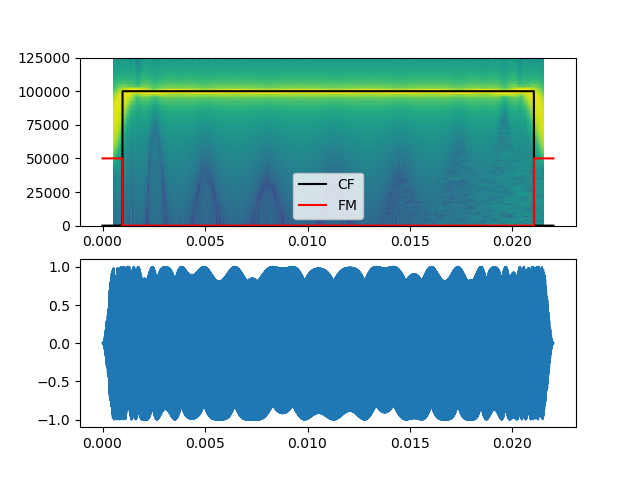

In [55]:
plt.figure()
q0 =plt.subplot(211)
plt.specgram(eg_call, Fs=fs, NFFT=256, noverlap=255)
plt.plot(make_t(cf,fs),cf*100000,'k',label='CF')
plt.plot(make_t(fm,fs),fm*50000, 'r',label='FM')
plt.legend()
plt.subplot(212, sharex=q0)
plt.plot(make_t(eg_call,fs), eg_call)


In [56]:
fm.size

5500

In [61]:
half_way = int(fm.size/2.0)
np.sum(fm[:half_way])/fs, np.sum(fm[half_way:])/fs

(0.000972, 0.000956)

In [30]:
def draw_percentile_line(X, pctile=5):
    threshold = np.percentile(X, pctile)
    plt.hlines(threshold, 0, X.size)
    return threshold

In [31]:
def make_threshold_plot(cf_dbrms, fm_dbrms, fs):
    threshold = np.arange(10,90)
    common_samples = []
    total_fm_samples = []
    total_cf_samples = []
    for each in threshold:
        fm_samples = fm_dbrms >= np.percentile(fm_dbrms, each)
        cf_samples = cf_dbrms >= np.percentile(cf_dbrms, 100-each)
        cf_and_fm_samples = np.sum(np.logical_and(fm_samples, cf_samples))

        total_fm_samples.append(np.sum(fm_samples))
        total_cf_samples.append(np.sum(cf_samples))
        common_samples.append(cf_and_fm_samples)
    
    # now choose threshold which minimises sample overlap and maximises number of fm+cf durations!
    threshold_for_least_common = threshold[np.argmin(common_samples)]
    total_durns = np.array(total_cf_samples)+np.array(total_fm_samples)
    threshold_for_maximum_durns = threshold[np.argmax(total_durns)]
    optimum_threshold = threshold_for_least_common*0.05 + threshold_for_maximum_durns*0.95
    print(threshold_for_least_common, threshold_for_maximum_durns)
    return optimum_threshold, [common_samples, total_durns], threshold        

### Using two separate percentile thresholds
The make_threshold_plot used a single percentil threshold to segment the FM + Cf parts. What if we run them independently. I'm thinking of doing this because sometimes the rms value distributions in the post-filtered only FM + only CF calls are likely to be very different. 

In [32]:
def get_two_thresholds(cf_dbrms, fm_dbrms, fs):
    fm_threshold = np.arange(10,90)
    cf_threshold = np.flip(fm_threshold)
    fm_cf_duration = []
    fm_and_cf_thresholds = []
    num_shared_fm_cf_samples = []
    for each in fm_threshold:
        for each_cf in cf_threshold:
            fm_and_cf_thresholds.append((each, each_cf))
            fm_samples = fm_dbrms >= np.percentile(fm_dbrms, each)
            cf_samples = cf_dbrms >= np.percentile(cf_dbrms, each_cf)

            common_fmcf_samples = np.sum(np.logical_and(cf_samples, fm_samples))
            num_shared_fm_cf_samples.append(common_fmcf_samples)

            cf_and_fm_samples = np.sum(fm_samples)+ np.sum(cf_samples)
            fm_cf_duration.append(cf_and_fm_samples)

    # choose the parameter region that will allow the best compromise between number of common fm_cf samples 
    # and the longest fm_cf durations. 
    optimisation_metric = 1/np.array(num_shared_fm_cf_samples)
    index_w_most_fm_and_cf_samples = np.argmax(optimisation_metric)
    best_threshold = fm_and_cf_thresholds[index_w_most_fm_and_cf_samples]
    
    return best_threshold, [fm_cf_duration, num_shared_fm_cf_samples] ,fm_and_cf_thresholds  

In [33]:
def get_thresholds_re_max(cf_dbrms, fm_dbrms):
    '''
    '''
    fm_threshold = np.arange(-10,0)
    cf_threshold = np.arange(-10,0)
    fm_db_re_max = fm_dbrms - np.max(fm_dbrms)
    cf_db_re_max = cf_dbrms - np.max(cf_dbrms)

    fm_cf_duration = []
    fm_and_cf_thresholds = []
    num_shared_fm_cf_samples = []
    for each_fm in fm_threshold:
        for each_cf in cf_threshold:
            fm_and_cf_thresholds.append((each_fm, each_cf))
            fm_samples = fm_db_re_max >= each_fm
            cf_samples = cf_db_re_max >= each_cf

            common_fmcf_samples = np.sum(np.logical_and(cf_samples, fm_samples))
            num_shared_fm_cf_samples.append(common_fmcf_samples)

            cf_and_fm_samples = np.sum(cf_samples)*np.sum(fm_samples)
            fm_cf_duration.append(cf_and_fm_samples)

    # choose the parameter region that will allow the best compromise between number of common fm_cf samples 
    # and the longest fm_cf durations. 
    optimisation_metric = np.array(num_shared_fm_cf_samples)/np.array(cf_and_fm_samples)
    best_index = np.argmin(optimisation_metric)
    best_threshold = fm_and_cf_thresholds[best_index]
    
    return num_shared_fm_cf_samples, optimisation_metric, best_threshold

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


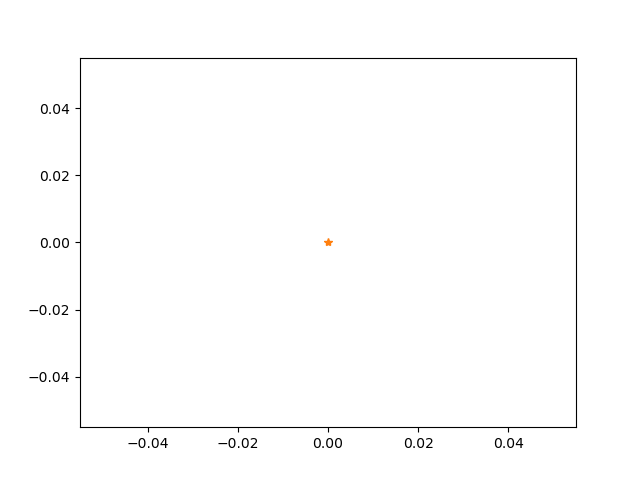

(-10, -10)


In [34]:
comm, opt, thres = get_thresholds_re_max(cf_dbrms, fm_dbrms)
plt.figure()
plt.plot(opt)
plt.plot(np.argmin(opt), comm[np.argmin(opt)],'*')
print(thres)

<IPython.core.display.Javascript object>


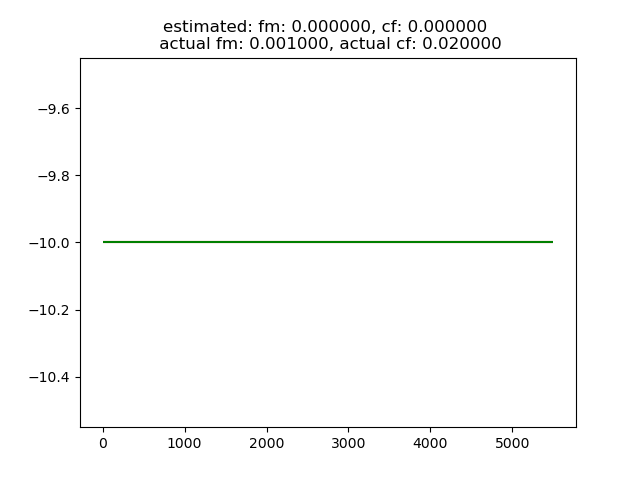

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


Text(0.5, 1.0, 'estimated: fm: 0.000000, cf: 0.000000 \n actual fm: 0.001000, actual cf: 0.020000')

In [35]:
plt.figure()
plt.plot(fm_dbrms-np.max(fm_dbrms),'r')
plt.hlines(thres[0],0,fm_dbrms.size,'r')
plt.plot(cf_dbrms-np.max(cf_dbrms),'g')
plt.hlines(thres[1],0,cf_dbrms.size,'g')

fm_total_durn = np.sum(fm_dbrms-np.max(fm_dbrms)>=thres[0])/fs
cf_total_durn = np.sum(cf_dbrms-np.max(cf_dbrms)>=thres[1])/fs
plt.title( 'estimated: fm: %f, cf: %f \n actual fm: %f, actual cf: %f'%(fm_total_durn*0.5, cf_total_durn, fm_durn, cf_durn))

In [36]:
o_thr,[fmcf_durn, common], thresholds = get_two_thresholds(cf_dbrms, fm_dbrms, fs)
print(o_thr)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


(10, 89)


C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [37]:
thresholds[78:82]

[(10, 11), (10, 10), (11, 89), (11, 88)]

In [38]:
common[78:82]

[0, 0, 0, 0]

<IPython.core.display.Javascript object>


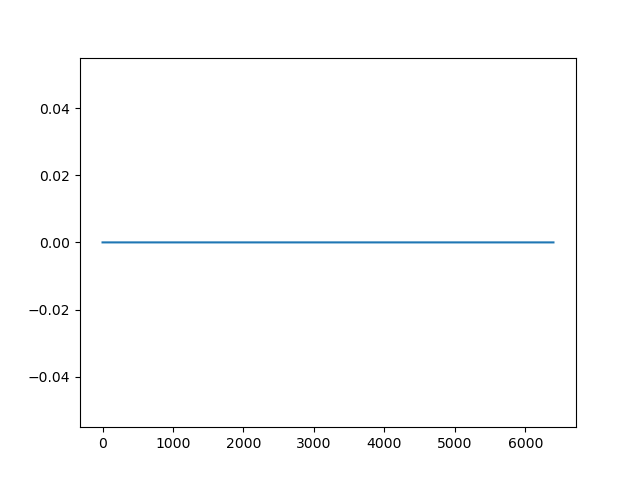

In [39]:
plt.figure()
plt.plot(np.array(fmcf_durn)-np.array(common))


<IPython.core.display.Javascript object>


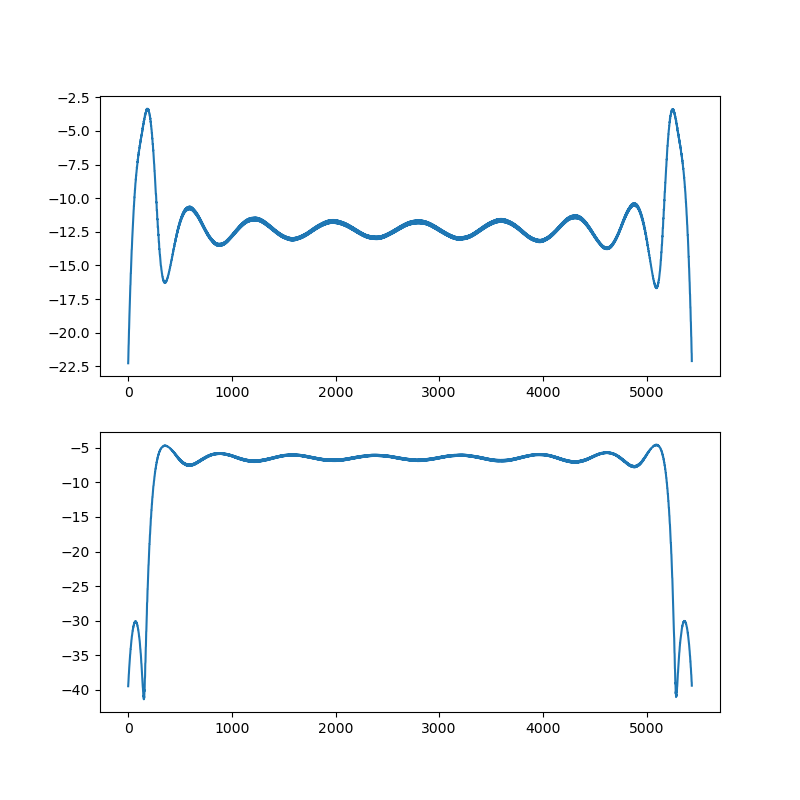

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(fm_dbrms)
fm_thresh = draw_percentile_line(fm_dbrms,80)
plt.subplot(212)
plt.plot(cf_dbrms)
cf_thresh = draw_percentile_line(cf_dbrms, o_thr[1])

In [41]:
o_thr,metric, thresholds = make_threshold_plot(fm_dbrms, cf_dbrms, fs)

10 10


C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


In [42]:
o_thr

10.0

<IPython.core.display.Javascript object>


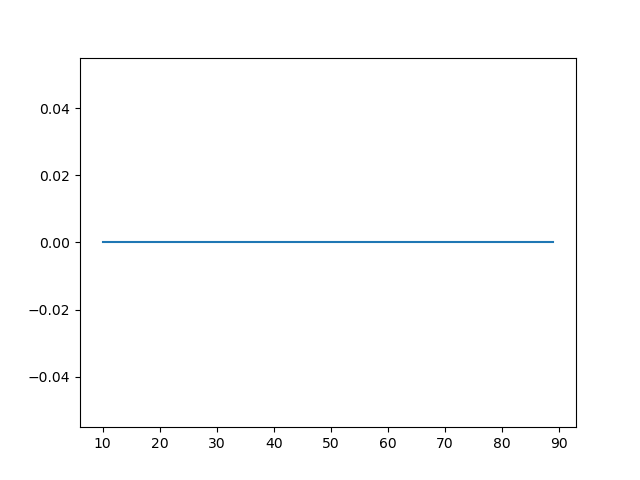

In [43]:
plt.figure()
#plt.plot(thresholds, metric[0])
plt.plot(thresholds, metric[1])
#plt.plot(o_thr, metric[int(np.argwhere(thresholds==o_thr)[0])],'*')
#plt.hlines(metric[int(np.argwhere(thresholds==o_thr)[0])],0,thresholds.size)


<IPython.core.display.Javascript object>


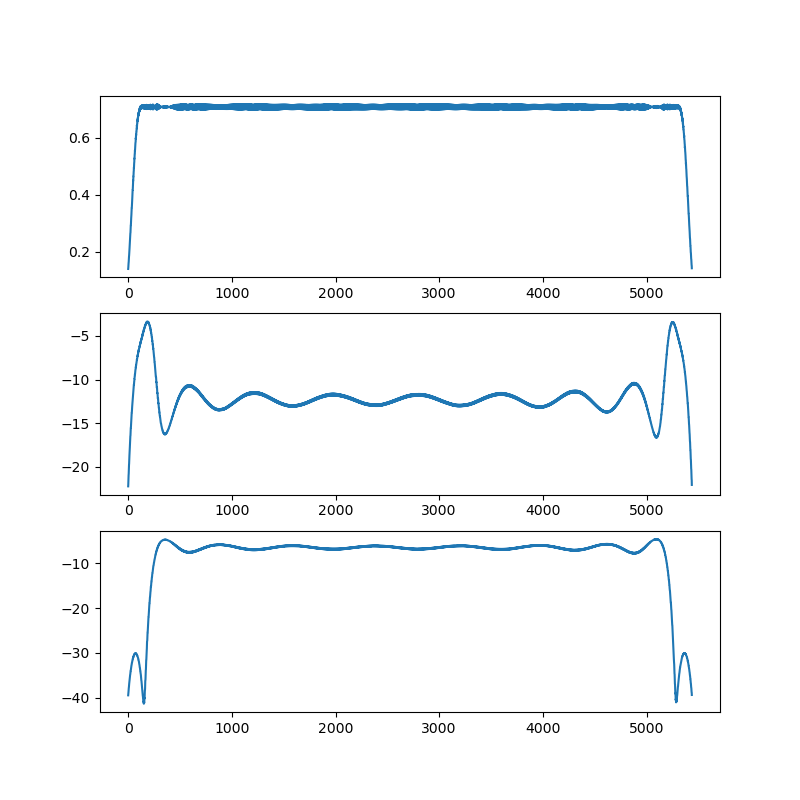

In [44]:
thresh = o_thr
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(call_rms)
draw_percentile_line(call_rms, o_thr)
plt.subplot(312)
plt.plot(fm_dbrms)
fm_thresh = draw_percentile_line(fm_dbrms,o_thr)

plt.subplot(313)
plt.plot(cf_dbrms)
cf_thresh = draw_percentile_line(cf_dbrms, 100-o_thr)


In [45]:
estim_fm_durn = np.sum(fm_dbrms>=fm_thresh)/fs
estim_cf_durn = np.sum(cf_dbrms>=cf_thresh)/fs

print(estim_cf_durn, estim_fm_durn/2, estim_cf_durn+estim_fm_durn)

0.0 0.0 0.0


C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.
C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


In [46]:
print(cf_durn, fm_durn, cf_durn+fm_durn*2 )

0.02 0.001 0.022


### Trying out with real data:

In [47]:
import glob 
import scipy.io.wavfile as wav

In [48]:
folder = os.path.join('real_data\\','well_cropped\\')
all_wav_files = glob.glob(folder+'*.wav')

fs_rec, real_call = wav.read(all_wav_files[3])
real_call_up = signal.resample(real_call, int(real_call.size*2.0))

cf_dbrms, fm_dbrms = pre_process_for_segmentation(real_call_up, fs_rec*2)
mask, re_max = identify_call_from_background(real_call_up, fs_rec*2, background_threshold=-30)
main_call = real_call_up[mask]

cf, fm, info = segment_call_into_cf_fm(main_call, fs_rec*2)

<IPython.core.display.Javascript object>


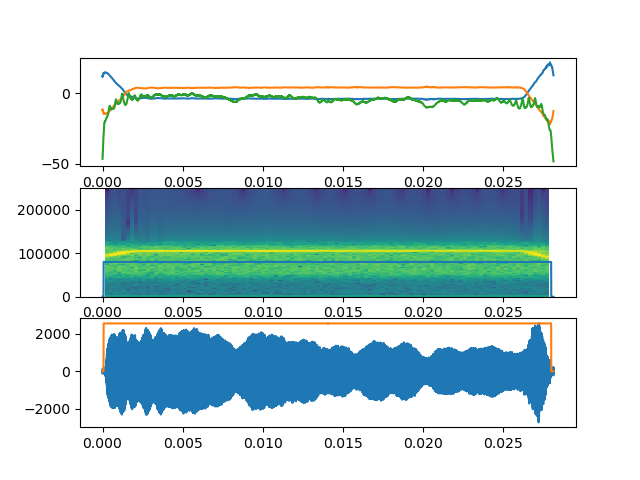

<IPython.core.display.Javascript object>


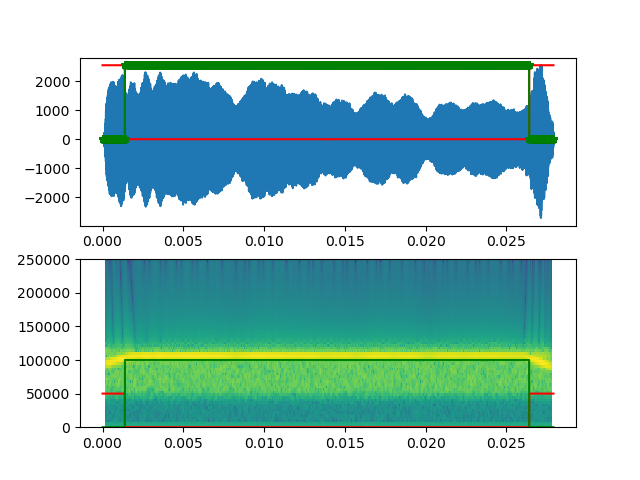

In [49]:
plt.figure()
b0 = plt.subplot(311)
plt.plot(make_t(fm_dbrms, fs_rec*2),fm_dbrms-cf_dbrms)
plt.plot(make_t(fm_dbrms, fs_rec*2), cf_dbrms-fm_dbrms)
plt.plot(make_t(re_max, fs_rec*2),re_max)
plt.subplot(312, sharex=b0)
plt.specgram(real_call_up, Fs=fs_rec*2.0);
plt.plot(make_t(mask, fs_rec*2), mask*80000)
plt.subplot(313, sharex=b0)
plt.plot(make_t(real_call_up, fs_rec*2), real_call_up)
plt.plot(make_t(mask, fs_rec*2),mask*np.max(real_call_up))

plt.figure()
g0 = plt.subplot(211)
plt.plot(make_t(main_call, fs_rec*2), main_call)
plt.plot(make_t(main_call, fs_rec*2),fm*np.max(main_call),'r-')
plt.plot(make_t(main_call, fs_rec*2),cf*np.max(main_call),'g-*')
plt.subplot(212, sharex=g0)
plt.specgram(main_call, Fs=fs_rec*2, NFFT=128, noverlap=127)
plt.plot(make_t(main_call, fs_rec*2),fm*50000,'r-')
plt.plot(make_t(main_call, fs_rec*2),cf*50000*2,'g-')


<IPython.core.display.Javascript object>


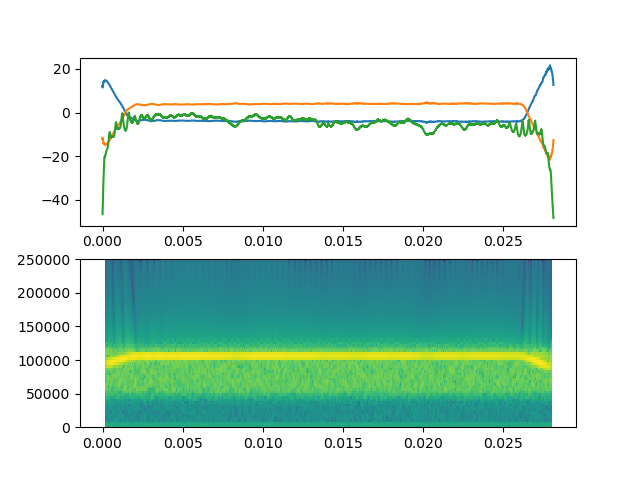

In [50]:
plt.figure()
c0 = plt.subplot(211)
plt.plot(make_t(fm_dbrms, fs_rec*2),fm_dbrms-cf_dbrms)
plt.plot(make_t(fm_dbrms, fs_rec*2), cf_dbrms-fm_dbrms)
plt.plot(make_t(fm_dbrms, fs_rec*2), re_max)

plt.subplot(212, sharex=c0)
plt.specgram(real_call_up, Fs=fs_rec*2.0, NFFT=128, noverlap=127);
